"""
 - data from https://www.kaggle.com/c/indoor-location-navigation
 - data conversion using main_interp_wtime.py based on time of the wifi recordings 
 - these area every 2.2-2.5 seconds, and their position is intyerpolated linearily assuming constant speed between waypoints 
 - BLE beacons are attached to the closes interpolated point 
 - actual waypoint in the data ay not appear in the json produced
"""

indoor_comp_import.png - example of resulted points (blue) 


In [1]:
from utils import *
import sys, os, random
# from compare_locations import compare_locations

datadir = "../indoor-location-competition-20/data/site1/"



In [395]:
import numpy as np
from scipy.spatial.distance import braycurtis
from scipy.stats import ks_2samp, chisquare
import copy 


def precalculate(c): # c is a collection
    """ creates new fields to speed up distance comparisons 
          c.ufingerprint['wifirssi'][mac] = average dBm 
    """
    ufingerprint = {}
    ufingerprint['wifirssi'] = {}
    for f in c['fingerprints']:
        if not "wifi" in f.keys():
            continue
        for mac in f["wifi"].keys():
            avg_pow = np.average(f["wifi"][mac]['rssi']) # each fingerprint (direction) counts the same
            if not mac in ufingerprint["wifirssi"].keys():
                ufingerprint["wifirssi"][mac] = [avg_pow] 
            else:
                ufingerprint["wifirssi"][mac].append(avg_pow)
    for mac in ufingerprint["wifirssi"].keys():
        ufingerprint["wifirssi"][mac] = \
            np.average(adjust_rssi(ufingerprint["wifirssi"][mac])) #each fingerprint (direction) counts the same
    c['ufingerprint'] = ufingerprint
                
def merge_wifi_fingerprints1(flist):
    if len(flist) == 1:
        return flist[0]
    fingerprint = copy.deepcopy(flist[0])
    for f2 in copy.deepcopy(flist[1:]):
        if not "wifi" in f2.keys():
            continue
        for mac in f2["wifi"].keys():
            if not mac in fingerprint["wifi"].keys():
                fingerprint["wifi"][mac] = f2["wifi"][mac]
            else:
                fingerprint["wifi"][mac]['rssi'].extend(f2["wifi"][mac]['rssi'])
            fingerprint["wifi"][mac]['rssi'].sort()    
    return fingerprint

def compare_locations(c1, c2, simil_method = braycurtis,  selection = 'Average', dif = True):
    # precalculated with average, adjust_rssi  
    wifi1 = c1['ufingerprint']['wifirssi']
    wifi2 = c2['ufingerprint']['wifirssi']      
    
    common_aps = list(set(wifi1.keys()) & set(wifi2.keys()))
    # No APs in common -> similarity = 1
    if not common_aps:
        return 1.0

    if len(common_aps) * 5 <= len(wifi1.keys()) or len(common_aps) < 3:
        return 1.0

    aps1 = set(wifi1.keys()) - set(common_aps)
    aps2 = set(wifi2.keys()) - set(common_aps)
    rssi1 = np.empty(len(common_aps) + len(aps1) + len(aps2), dtype=float)
    rssi2 = np.empty(len(common_aps) + len(aps1) + len(aps2), dtype=float)
    nap = 0   #  
    
    if selection == 'First':
        for ap in common_aps:
            rssi1.append(wifi1[ap]['rssi'][0])
            rssi2.append(wifi2[ap]['rssi'][0])

        # Make an average of all RSSI values
    if selection == 'Average':
        for ap in common_aps:
            rssi1[nap] = wifi1[ap]
            rssi2[nap] = wifi2[ap]
            nap = nap + 1
            
    if selection == 'Median':
        for ap in common_aps:
            rssi1.append(np.median(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.median(adjust_rssi(wifi2[ap]['rssi'])))

    if selection == 'Mean':
        for ap in common_aps:
            rssi1.append(np.mean(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.mean(adjust_rssi(wifi2[ap]['rssi'])))

    if selection == 'Std':
        for ap in common_aps:
            rssi1.append(np.std(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.std(adjust_rssi(wifi2[ap]['rssi'])))

    if selection == 'Max':
        for ap in common_aps:
            rssi1.append(np.max(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.max(adjust_rssi(wifi2[ap]['rssi'])))
            
    if selection == 'KS':
        for ap in common_aps:
            _, p = ks_2samp(wifi1[ap]['rssi'], wifi2[ap]['rssi'])
            rssi1.append(p)
            rssi2.append(1.0)

    if (dif == True) and (selection != 'KS'):
        if len(rssi1) > nap:
            rssi1[nap] = rssi1[0]
            rssi2[nap] = rssi2[0]
        rssi1 = np.diff(rssi1, append=rssi1[0])
        rssi2 = np.diff(rssi2, append=rssi1[0])   

   
    """
    p1 = np.mean(list(map(lambda a: np.mean(wifi1[a]['rssi']), wifi1.keys())))
    p2 = np.mean(list(map(lambda a: np.mean(wifi2[a]['rssi']), wifi2.keys())))
    pc1 = np.mean(list(map(lambda a: np.mean(wifi1[a]['rssi']), common_aps)))
    pc2 = np.mean(list(map(lambda a: np.mean(wifi2[a]['rssi']), common_aps)))
    po1 = np.mean(list(map(lambda a: np.mean(wifi1[a]['rssi']), aps1)))
    po2 = np.mean(list(map(lambda a: np.mean(wifi2[a]['rssi']), aps2)))        
    iou = len(common_aps) / \
        (len(aps1) + len(aps2) + len(common_aps))
    """
        
    for ap in aps1:
        rssi1[nap] = 1.0*wifi1[ap]
        rssi2[nap] = adjust_rssi(-95.0)[0]
        nap = nap + 1
    for ap in aps2:
        rssi2[nap] = 1.0*wifi2[ap]
        rssi1[nap] = adjust_rssi(-95.0)[0]
        nap = nap + 1
        
    return simil_method(rssi1, rssi2)



In [8]:
etaje_fnames = [
"F1.intw.json.gz"]
 
etaje = []
for e in etaje_fnames: 
    json_file = os.path.join(datadir, e)
    etaj = load_dataset_json(json_file)
    etaje.append(etaj)

e = 0
for c in etaje[e]:
    precalculate(c)
    

In [396]:
# test all points on a floor versus randomly chosen points, retain only ones under 20m
# results ~ 8000 points 

before = datetime.datetime.now()
e = 0
npct = len(etaje[e])
bd = []
ks = np.array([])
avg = np.array([])
md = np.array([])
r = np.arange(0, npct)
for point in r: 
    ra = np.random.choice(range(0,npct), size=150, replace=True)
    for p in ra:
        if p == point: 
            continue 
        eu_dist = euclidean([etaje[e][point]['x'], etaje[e][point]['y'], etaje[e][point]['z']], 
                                [etaje[e][p]['x'], etaje[e][p]['y'], etaje[e][p]['z']]) 
        if eu_dist < 10.0: 
            bd.append([ point, p, eu_dist, 
                compare_locations(etaje[e][point], etaje[e][p], dif=True)])
            
after = datetime.datetime.now()
print(f"{len(bd)} pairs in {(after-before).seconds} seconds")

8364 pairs in 23 seconds


In [400]:
#for r in bd:
#    if r[3] < 0.00001:
#        print(r)
        
"""
[416, 748, 7.965968698262095, 1.1432752822343531e-104]
[447, 484, 5.666789344349382, 4.5171232256299075e-201]
[1587, 547, 2.2512610534178323, 2.6381857170980354e-170]
[1607, 1837, 9.006204040847948, 2.2652075362398073e-191]
[1734, 1745, 8.76914146486692, 3.0943561441516074e-176]
[2099, 978, 7.17004766220542, 4.010973373557013e-307]
[2158, 2085, 9.951403966289325, 1.7564582159551074e-09]
[2183, 973, 8.704490359475045, 4.024471425730397e-35]
[2194, 2195, 2.152325677936656, 5.1076903137639595e-157]

[125, 1068, 8.310660890480536, 1.1056010816989343e-264]
[125, 1069, 9.194377692868553, 9.769207917595212e-242]
[971, 970, 1.6643837700362687, 2.0182875683049764e-09]
[971, 970, 1.6643837700362687, 2.0182875683049764e-09]
[972, 971, 4.31608232908528, 9.449575689369214e-308]
[973, 1883, 5.216228226974052, 1.273631340140865e-35]
[974, 2178, 4.376432201204703, 3.6372952179111085e-307]
[1516, 1811, 6.610572912634125, 1.05817353692996e-152]
[1618, 1616, 3.452917106303941, 3.5196310669811134e-300]
[1667, 2281, 8.692077646973896, 1.2005461504852361e-226]
[1667, 2280, 8.283797113896535, 1.2270394895238887e-226]
[1731, 2190, 9.053081675861533, 2.2678232472198642e-176]
[1773, 2194, 9.52878042067298, 1.105474686632271e-255]
[1828, 1846, 6.563219071313907, 8.803316662823055e-296]
[1940, 1945, 7.146539748875515, 3.7067620103092914e-242]
"""
#print(compare_locations_old(etaje[e][447], etaje[e][484]))
print(compare_locations(etaje[e][447], etaje[e][484], dif=True))
#print(etaje[e][447]['ufingerprint']['wifirssi'])

0.6135917409427136


Slope = [0.0131069  0.25170116]


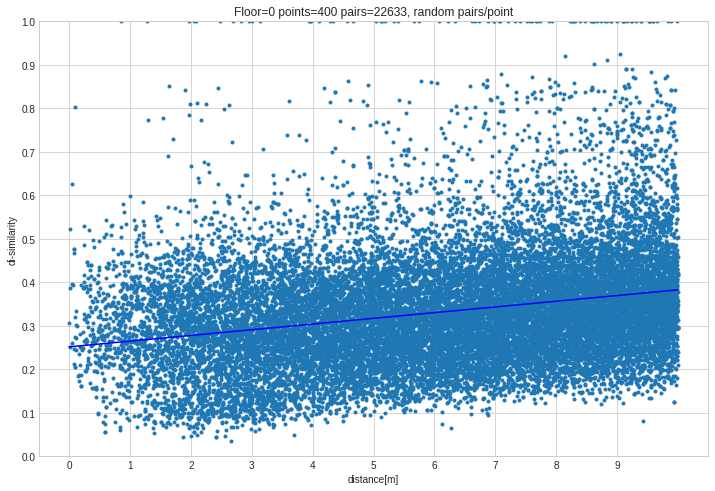

In [412]:
plt.style.use("seaborn-whitegrid")   
fig =  plt.figure(figsize=(12, 8))        
plt.plot([r[2] for r in bd] , [r[3] for r in bd], ".", label='bestdir')

m = np.polyfit([r[2] for r in bd] , [r[3] for r in bd], 1)
print(f"Slope = {m}")
predict = np.poly1d(m)
x_lin_reg = range(0, 11)
y_lin_reg = predict(x_lin_reg)
plt.plot(x_lin_reg, y_lin_reg, c = 'b')

plt.xlabel('distance[m]')
plt.ylabel('di-similarity')
plt.grid(True)
plt.title(f"Floor={e} points={npct} pairs={len(bd)}, random pairs/point")
plt.xticks(range(0, 10))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim(0, 1.0)
#plt.legend(loc="upper right",shadow=True, fancybox=True)
plt.show()
#fig.savefig(f"Braycurtis_vs_dist_floor{len(etaje)}_8000pts.pdf", bbox_inches='tight')

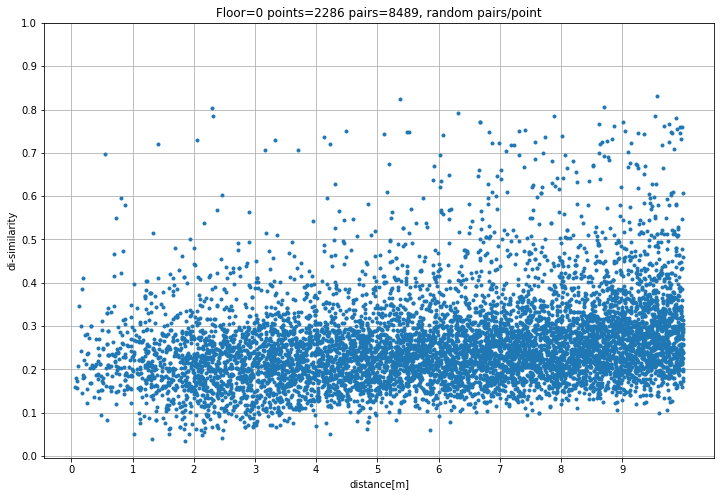

In [56]:
#grid structure contains list of points for each square of size 10(gridsize) 
# for a point x,y in grid[x/10][y/10] its neighbors are in 8-neighborhood 
# at most 10m away 

gridsize = 10 # 10 meter grid
e = 0
maxx = -10000
maxy = -10000
for c in etaje[e]:
    if c['x'] > maxx:
        maxx = c['x']
    if c['y'] > maxy:
        maxy = c['y']

        
# allocate 1 extra row column so that we test 8-neighborhood    
grid = [] 
for r in range(0, 2 + int(maxx/gridsize)):
    grid.append([[]] * (2 + int(maxy/gridsize)))

for gx in range(0, 2 + int(maxx/gridsize)):
    for gy in range(0, 2 + int(maxy/gridsize)):
        grid[gx][gy] = [] # Python love is beginning to fade

maxgsize = 0     
sumgsize = 0 
for c in range(0, len(etaje[e])):
    gx = int(etaje[e][c]['x'] / gridsize ) # my grid
    gy = int(etaje[e][c]['y'] / gridsize )
    grid[gx][gy].append(c) # grid[gx][gy] is an index in etaj[e][]
    #print(type(grid[gx][gy]), type(len(grid[gx][gy])), type(maxgsize))
    if len(grid[gx][gy]) > maxgsize:
        maxgsize = len(grid[gx][gy])
    sumgsize = sumgsize + len(grid[gx][gy])    

print(f"maxx={maxx:.1f}, maxy={maxy:.1f} maxgridlen={maxgsize} avggridlen={sumgsize/len(etaje[e]):.2f}")

#print(grid)    
        
#for gx in range(0, 1 + int(maxx/gridsize)):
#    for gy in range(0, 1 + int(maxy/gridsize)):
#        if len(grid[gx][gy]) > 0:
#            print(gx, gy, len(grid[gx][gy]))
    
    

maxx=239.0, maxy=167.7 maxgridlen=46 avggridlen=11.54


In [57]:
# precompute list of nearby points, < 10.0 meters 
# for point i in etaj e, nbrs[i] contain a list of indices of points  

before = datetime.datetime.now()
e = 0
npct = len(etaje[e])
nbrs = [] 
nnbrs = 0 
for q in np.arange(0, npct): 
    
    gx = int(etaje[e][q]['x'] / gridsize ) # my grid
    gy = int(etaje[e][q]['y'] / gridsize )
    nbrsq = []
    
    for gi in range(gx-1,gx+2):
        for gj in range(gy-1,gy+2):
            for p in grid[gi][gj]:
                if p == q: 
                    continue 
                eu_dist = euclidean([etaje[e][q]['x'], etaje[e][q]['y'], etaje[e][q]['z']], 
                        [etaje[e][p]['x'], etaje[e][p]['y'], etaje[e][p]['z']]) 
                # we hope not to have 10m errors- if yes, increase  this value and rerun
                if eu_dist < 10.0: 
                    nbrsq.append(p)
    nbrs.append(nbrsq)
    nnbrs = nnbrs + len(nbrsq)
after = datetime.datetime.now()
print(f"{len(nbrs)} points, {nnbrs/len(nbrs):.1f} neighbors on average;  in {(after-before).seconds} seconds")
#print(nbrs)

2286 points, 56.8 neighbors on average;  in 4 seconds


In [410]:
# compute similarities using nbrs datastructure with neighbors < 10m 

before = datetime.datetime.now()
e = 0
npct = 400 
bd = []
ks = np.array([])
avg = np.array([])
md = np.array([])
ra = np.random.choice(range(0,len(etaje[e])), size=npct, replace=False)
mindl = []
minsl = []
for q in ra: 
    mindisim = 10.0 
    mindist = 100
    for p in nbrs[q]:
        eu_dist = euclidean([etaje[e][q]['x'], etaje[e][q]['y'], etaje[e][q]['z']], 
                                [etaje[e][p]['x'], etaje[e][p]['y'], etaje[e][p]['z']]) 
        disim = compare_locations(etaje[e][q], etaje[e][p], dif=False)
        bd.append([ q, p, eu_dist, disim])
        if disim < mindisim:
            mindisim = disim
            mindist = eu_dist
    mindl.append(mindist)  # keep the euclidean distance for the smallest disimilarity       
    minsl.append(mindisim) 
after = datetime.datetime.now()
print(f"{len(bd)} (grid)pairs in {(after-before).seconds} seconds")

22633 (grid)pairs in 46 seconds


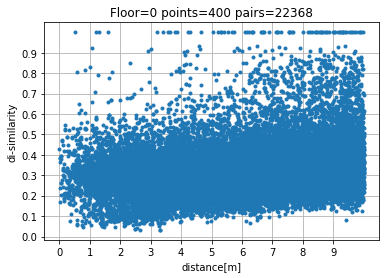

In [402]:
fig =  plt.figure(figsize=(6, 4))        
plt.plot([r[2] for r in bd] , [r[3] for r in bd], ".", label='bestdir')
   
plt.xlabel('distance[m]')
plt.ylabel('di-similarity')
plt.grid(True)
plt.title(f"Floor={e} points={npct} pairs={len(bd)}")
plt.xticks(range(0, 10))
plt.yticks(np.arange(0, 1, 0.1))
#plt.legend(loc="upper right",shadow=True, fancybox=True)
plt.show()
#fig.savefig(f"Braycurtis_vs_dist_floor{len(etaje)}_8000pts.pdf", bbox_inches='tight')

After precalculation & some optimization: 12495 pairs in 40 seconds:
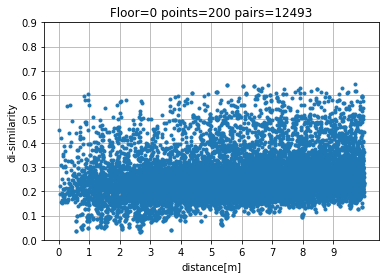

F1 200 points, neighbors selected from grid of 10m
23406 pairs in 610 seconds
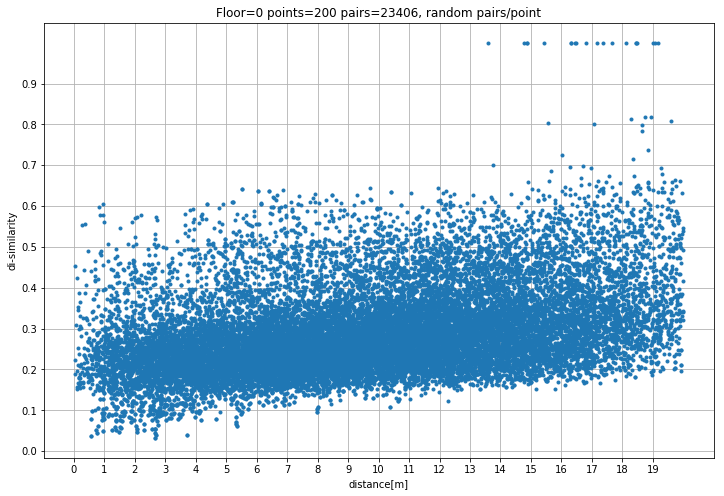


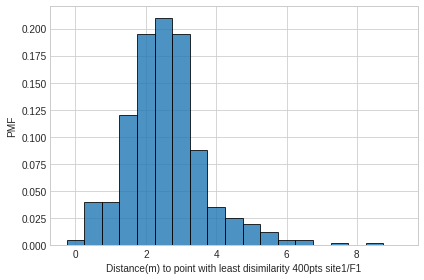

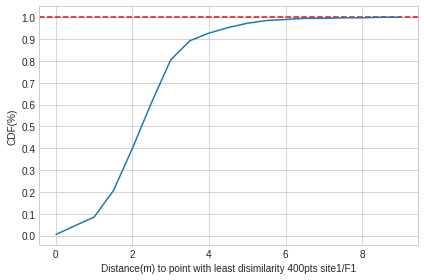

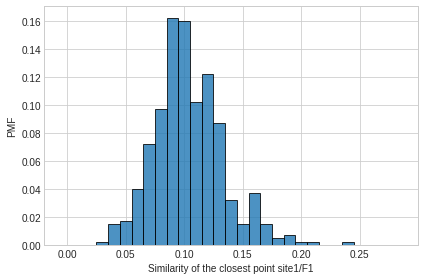

In [413]:
#mindl = list of distances to closest pt 
#minsl = list of similarities to closest pt 

b = np.arange(0, 10, 0.5) # Bins of histogram - from 1 to 5 
bin_width = b[1] - b[0]
hist_sim, bins_out = np.histogram(np.array(mindl), b, density=False)
hist_sim = hist_sim / len(mindl)
fig = plt.figure()
plt.bar(b[:-1], hist_sim, width=bin_width, ec='k', alpha=0.8)
plt.xlabel("Distance(m) to point with least disimilarity 400pts site1/F1")
plt.ylabel("PMF")
#plt.title("{} {} \n{}{}".format("median ", np.median(cl_dist), len(cl_sim), " points;"))
plt.tight_layout()
plt.show()

cdf=np.cumsum(hist_sim)
plt.axhline(y=1, color='r', linestyle='--')
plt.xlabel("Distance(m) to point with least disimilarity 400pts site1/F1")
plt.ylabel("CDF(%)")
plt.plot(b[:-1], cdf)
plt.grid(True)
plt.yticks(np.arange(0, 1.05, step=0.1))
plt.tight_layout()
plt.show()

b = np.arange(0, 0.3, 0.01) # Bins of histogram - from 1 to 5 
bin_width = b[1] - b[0]
hist_sim, bins_out = np.histogram(np.array(minsl), b, density=False)
hist_sim = hist_sim / len(minsl)
fig = plt.figure()
plt.bar(b[:-1], hist_sim, width=bin_width, ec='k', alpha=0.8)
plt.xlabel("Similarity of the closest point site1/F1")
plt.ylabel("PMF")
#plt.title("{} {}{}".format("Cross validation Dataset2", len(cl_sim), " points;"))
plt.tight_layout()
plt.show()
#fig.savefig(f"disim-cross-dataset2.pdf", bbox_inches='tight')


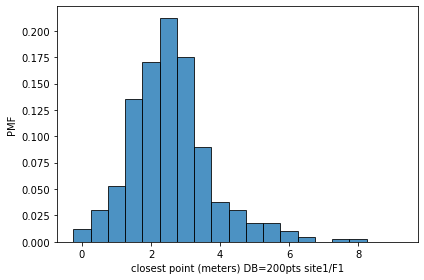
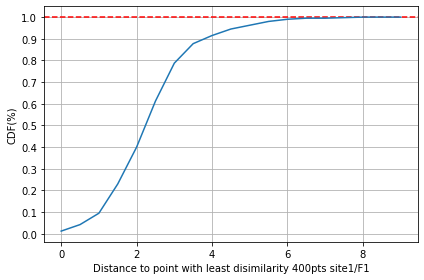

In [405]:
before = datetime.datetime.now()
rez = []
for p in range(1, len(etaje[0])):
    rez.append(compare_locations(etaje[0][0], etaje[0][p], selection = 'Average'))
    rez.append(compare_locations(etaje[0][1], etaje[0][p], selection = 'Average'))
after = datetime.datetime.now()
print(f"{len(rez)} pairs in {(after-before).seconds:.3f} seconds")

4570 pairs in 15.000 seconds


In [406]:
print("3-565 ", compare_locations(etaje[e][3], etaje[e][565], selection = 'Average', verbose=True))

TypeError: compare_locations() got an unexpected keyword argument 'verbose'

In [243]:
print("3-565 ", compare_locations(etaje[e][3], etaje[e][565], selection = 'Average'))

print(etaje[e][3]['fingerprints'][0]['wifi']['1a:74:9c:2b:61:6a'], "\n",
      etaje[e][565]['fingerprints'][0]['wifi']['1a:74:9c:2b:61:6a'])


print(etaje[e][3]['ufingerprint']['wifirssi']['1a:74:9c:2b:61:6a'],
      etaje[e][565]['ufingerprint']['wifirssi']['1a:74:9c:2b:61:6a'])
#for r in bd:
#    if r[2] <  0.5 and r[3] > 0.4:
#        print(r[0], "--", r[1], "<", 
#              compare_locations(etaje[e][r[1]], etaje[e][r[0]], selection = 'Average'), \
#              ">", r[2],"m", r[3], "dis")
        

3-565  0.42340117783059433
{'rssi': [-56]} 
 {'rssi': [-36]}
-56.0 -36.0


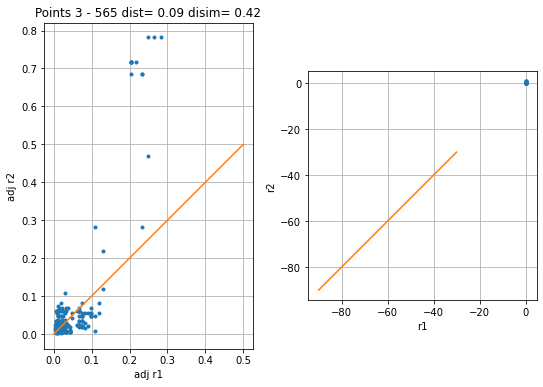

(0.42340117783059433, 0.14427089828340922, 1.737034476818789, 0.08719401223526436)


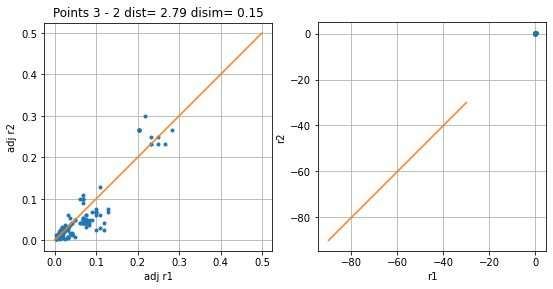

(0.15156474698423472, 0.06121206854917262, 0.3381459125982452, 2.7889435039927686)
(0.15554580828897785, 0.0, 0.4875468846560531, 2.738308122649402)


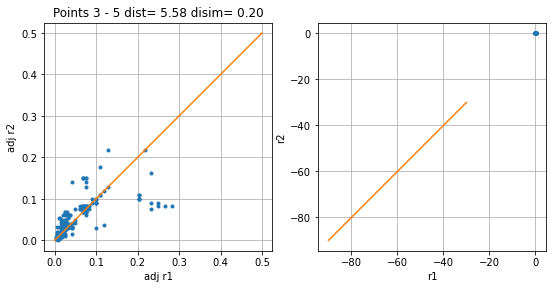

(0.20411115240406227, 0.0854334509099449, 0.5779030653238925, 5.580552028056294)


In [409]:

def compare_points(p1, p2, graph = False):
    c1 = etaje[e][p1]
    c2 = etaje[e][p2]

    common_aps = list(set(c1['ufingerprint']['wifirssi'].keys()) & set(c2['ufingerprint']['wifirssi'].keys()))
    r1 = [c1['ufingerprint']['wifirssi'][x] for x in common_aps]
    r2 = [c2['ufingerprint']['wifirssi'][x] for x in common_aps]

    bc =  braycurtis(r1, r2)
    meddif = np.sqrt(np.median(np.abs(np.array(r1) - np.array(r2))))
    eu_ss = np.sqrt(np.sum(np.square(np.array(r1) - np.array(r2))))
    eu_dist = euclidean([c1['x'], c1['y'], c1['z']], 
                                [c2['x'], c2['y'], c2['z']]) 

    if graph:
        fig =  plt.figure(figsize=(9, 6))     
        ax = plt.subplot(1, 2, 1)
        ax.set_aspect('equal')
        plt.plot(r1, r2, ".", label='bestdir')
        plt.plot([-0,0.5], [-0,0.5], "-")
        plt.xlabel('adj r1')
        plt.ylabel('adj r2')
        plt.grid(True)
        plt.title(f"Points {p1} - {p2} dist= {eu_dist:.2f} disim= {bc:.2f}" )
        #plt.xticks(range(-90, -30, 5))
        #plt.yticks(range(-90, -30, 5))
        #plt.legend(loc="upper right",shadow=True, fancybox=True)
        #plt.show()


        
        ax = plt.subplot(1, 2, 2)
        ax.set_aspect('equal')
        plt.plot(r1, r2, ".", label='')
        plt.plot([-90,-30], [-90,-30], "-")
        plt.xlabel('r1')
        plt.ylabel('r2')
        plt.grid(True)
        #plt.title(f"Floor={e} points={npct} pairs={len(bd)}")
        #plt.xticks(range(-90, -30, 5))
        #plt.yticks(range(-90, -30, 5))
        #plt.legend(loc="upper right",shadow=True, fancybox=True)
        plt.show()

    #print("disim = ", braycurtis(adjust_rssi(r1), adjust_rssi(r2)))
    #print("median diff = ", np.sqrt(np.median(np.abs(np.array(adjust_rssi(r1)) - np.array(adjust_rssi(r2))))))
    #print("eu = ", np.sqrt(np.sum(np.square(np.array(adjust_rssi(r1)) - np.array(adjust_rssi(r2))))))
    
    return (bc, meddif, eu_ss, eu_dist)


print(compare_points(3, 565, True))
print(compare_points(3, 2, True))
print(compare_points(3, 4, False))
print(compare_points(3, 5, True))



